## Feature extraction from infrared sky images for solar energy estimation

In recent years the idea of a transition to renewable energy sources has progressively gained more strength. Within this movement, solar energy is classified as one of the most important, being a clean alternative to traditional electricity generation systems.

To maximize solar energy production, it is important to have information on atmospheric conditions, especially incident solar radiation. Satellite images have been used to study atmospheric features such as cloud cover and solar radiation estimates. In this field, sky cameras have emerged as a promising technology to study sky conditions with greater precision. These cameras offer a view of the sky with high spatial resolution. Combining satellite images and sky cameras has proven effective in predicting the presence of clouds in the short term. [1] This information is key to adapt the operation of solar power plants to meteorological conditions and achieve better integration of the electricity generated into the grid. 

The objective of this work is to extract features from images gathered with an infrared sky cam on panoramic sky images, for intra-hour solar estiamtion. To achieve this several techniques from image analysis and vision image will be implemented into a single pipeline to obtain the relevant data for further use as inputs in solar prediction models. 

### 1. Image preprocessing 

For this specific work the images received were formated as .jp2 files, to handle this type of files the `imageio` library was used. The file type that is loaded is of type `Uint16`.

uint16


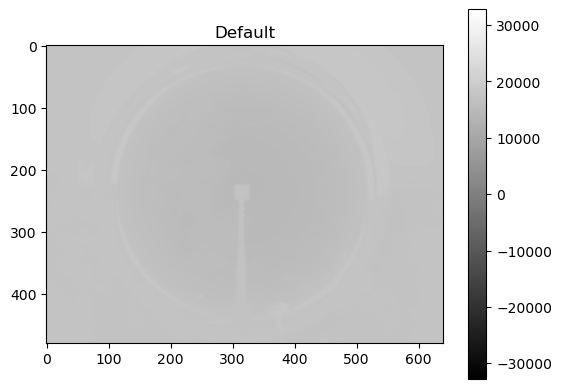

In [310]:
import imageio.v2 as imageio
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# path to jp2 image
filepath = '20230807/20230807152030.jp2'

# Read the JP2 image
image = imageio.imread(filepath)
print(image.dtype)
# Showing image in default range
plt.imshow(image.astype(int), cmap="gray", vmin=(-2**16)/2-1, vmax=(2**16)/2-1)
plt.title("Default")
plt.colorbar()


Matplotlib by default makes a normalization process when displaying images, by linearly mapping the minimun and maximum values of the image to the `[0.0, 1.0]` interval. To view the image in better detail a color mapping can be applied. In the following example `jet` mapping is applied. Note that the image values in the `img` variable remain unchanged, however the image shown is in the range of `[14537, 18358]`, corresponding to the min and max values of the given image.

14537
18358


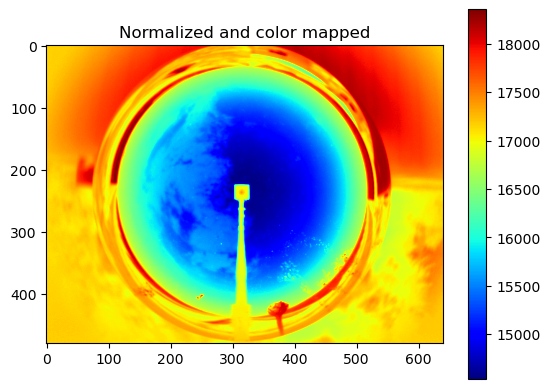

In [311]:
print(np.min(image))
print(np.max(image))
plt.imshow(image.astype(int), cmap="jet")
plt.title("Normalized and color mapped")
plt.colorbar()

`Uint16` is sometimes not the best way to work with image data, for ease of use in the following sections the img variable can be converted to `int32` instead.

In [312]:
# Image gets converted to int32
int_img = image.astype(int)
print(int_img.dtype)

int32


### 2. Image segmentation

The first step in the process of data extraction is to segment the clouds in the image. Several techniques can be applied to achieve this result. This approach consists of removing the background outside of the panoramic mirror as well as the camera with the camera stick. The resulting image then gets brightness adjusted by multiplying radial gradients, followed by a binarization based on brightness. 

The first step was removing the camera and the camera stick. For this part, a mask was previously made and saved in the file `camera.png`. The process consists of dividing the alpha channel of this file by 255, essentialy leaving only ones and zeros. This resulting alpha channel then gets multiplied to the image to process, then the zeros of the image get replaced to match the brightness of the lowest value -1 (unless its zero, which was never the case for all the captured images). 

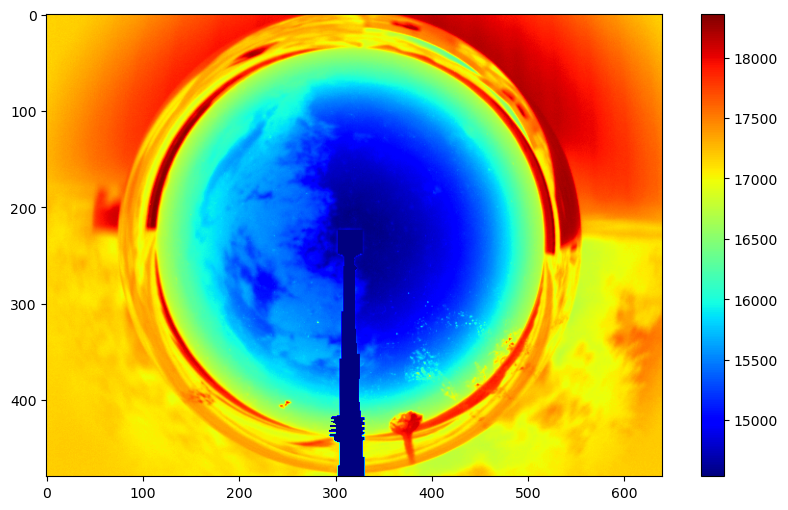

In [313]:
# # camera mask is multiplied to the image to make it the darkest part of it by -1
camara = Image.open('camera.png')
camara = np.asarray(camara)
# Only the alpha channel is needed, and is divided by 255 to get the number in the range [0,1]
slicee = camara[:,:,3]/255
img = int_img * slicee
img[img<1000] = np.max(np.min(int_img) - 1, 0)

plt.figure(figsize=(10,6))
plt.imshow(img, cmap="jet")
plt.colorbar()


The next step is to generate the radial gradients to multiply with the input image. This multiplication was done with the library blend modes. The library only accepts RGBA images as input, the current image is a single channel only, so the RGB layers are duplicates of this channel and the alpha layer is set to a constant opaque layer of ones. For this step the image itself was rescaled to be in the range of `[0,255]`, this step makes it lose some data from the original step, however it is neccesary as some functions only take as input images in the 8 bit range per channel.

(480, 640, 4)


Text(0.5, 1.0, 'Alpha channel')

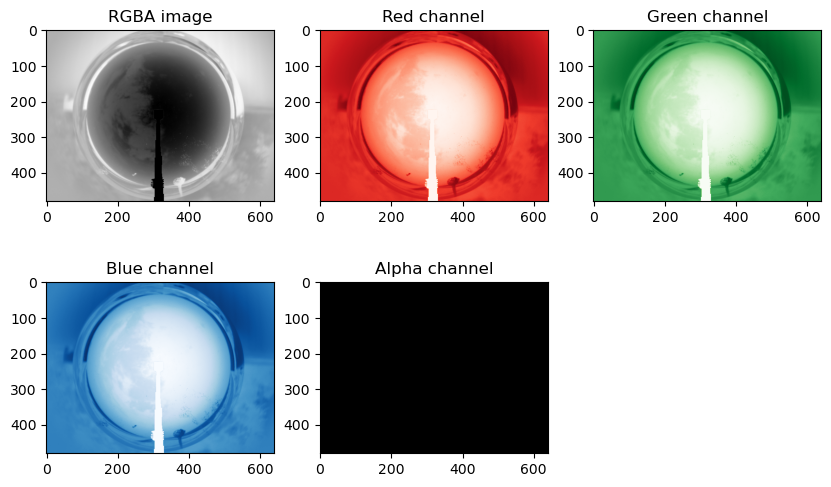

In [314]:
# The following function can be used to generate an RGBA image
def TwoDToRGBA (img):
    # Inputs to blend_modes need to be numpy arrays.
    background_img = np.array(img)  
    # Rescale the pixel values to the range [0, 255]
    scaled_img = ((background_img - np.min(background_img)) / (np.max(background_img) - np.min(background_img)) * 255).astype(np.uint8)
    # Creates an RGBA zeros image with the rescaled content
    rgba_image = np.zeros((background_img.shape[0], background_img.shape[1], 4), dtype=np.uint8)
    # The rescaled values get copied to every channel
    rgba_image[:, :, 0:3] = scaled_img[:, :, np.newaxis]
    # The alpha channel is set to a constant value of 255, for a fully opaque channel
    alpha_value = 255
    rgba_image[:, :, 3] = alpha_value
    # Now 'rgba_image' is an RGBA image with dimensions (~, ~, 4)
    return rgba_image

rgba_image = TwoDToRGBA (img)
print(rgba_image.shape)

plt.figure(figsize=(10,6))
plt.subplot(2, 3, 1)
plt.imshow(rgba_image)
plt.title("RGBA image")

plt.subplot(2, 3, 2)
plt.imshow(rgba_image[:,:,0], cmap="Reds")
plt.title("Red channel")

plt.subplot(2, 3, 3)
plt.imshow(rgba_image[:,:,1], cmap="Greens")
plt.title("Green channel")

plt.subplot(2, 3, 4)
plt.imshow(rgba_image[:,:,2], cmap="Blues")
plt.title("Blue channel")

plt.subplot(2, 3, 5)
plt.imshow(rgba_image[:,:,3], cmap="gray")
plt.title("Alpha channel")



In [315]:
import blend_modes

def create_radial_gradient(size, center, radius):

    y, x = np.ogrid[:size[0], :size[1]]
    distance = np.sqrt((x - center[1]) ** 2 + (y - center[0]) ** 2)
    gradient = 1 - np.clip(distance / radius, 0, 1)
    return gradient

def multiply_with_gradient(image, gradient, opacity):
    # Inputs to blend_modes need to be floats.
    background_img_float = image.astype(float)
    foreground_img_float = gradient.astype(float)
    blended_img_float = blend_modes.multiply(background_img_float, foreground_img_float, opacity)

    # Convert blended image back into PIL image
    blended_img = np.uint8(blended_img_float)  # Image needs to be converted back to uint8 type for PIL handling.
    # blended_img_raw = Image.fromarray(blended_img)  # Note that alpha channels are displayed in black by PIL by default.
    return blended_img

image_size = img.shape
gradient_center = (235, 314)  # Center of the gradient correponding to the center of the camera
gradient_radius = 210  # Radius of the gradient
gradient_1 = create_radial_gradient(image_size, gradient_center, gradient_radius)
rgba_grad_1 = TwoDToRGBA (gradient_1)

gradient_radius = 250  # Radius of the gradient
gradient_2 = create_radial_gradient(image_size, gradient_center, gradient_radius)
rgba_grad_2 = TwoDToRGBA (gradient_2)

first_grad = multiply_with_gradient(rgba_image, rgba_grad_1, 1)
second_grad = multiply_with_gradient(first_grad, rgba_grad_2, 1)


86.162109375


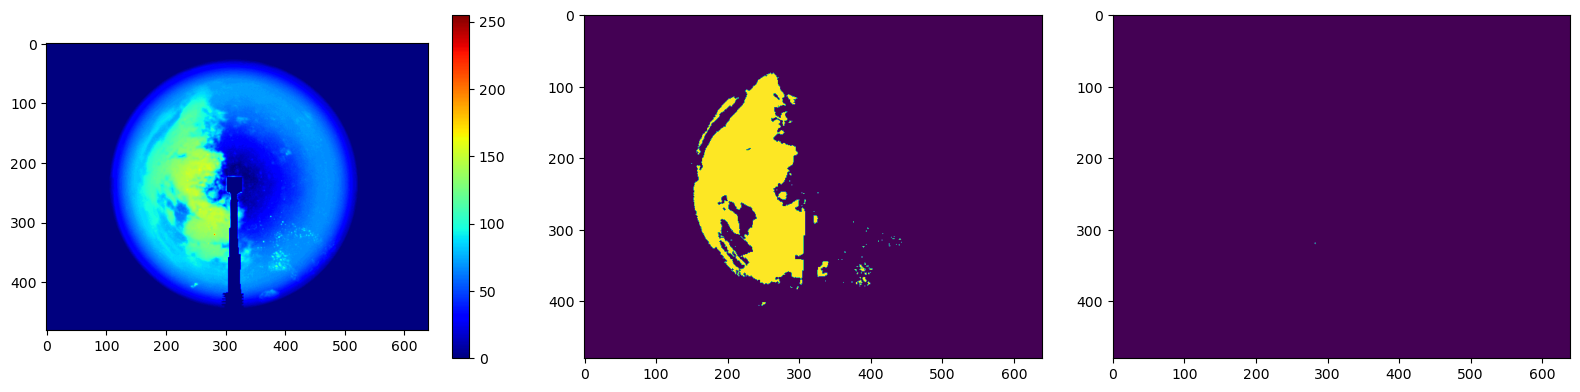

In [316]:
from skimage.filters import threshold_yen, gaussian

gauss = gaussian(first_grad[:,:,0], sigma=0.5)
scaled_img = ((gauss - np.min(gauss)) / (np.max(gauss) - np.min(gauss)) * 255)

thresh  = threshold_yen(scaled_img)
print(thresh)
binary = scaled_img > thresh
# fig, ax = try_all_threshold(scaled_img, figsize=(10, 6), verbose=False)
plt.figure(figsize=(16,4))
plt.subplot(1,3,1)
plt.imshow(scaled_img, cmap='jet')
plt.colorbar()

plt.subplot(1,3,2)
plt.imshow(binary)
plt.tight_layout()

plt.subplot(1,3,3)
mask = scaled_img > 180
plt.imshow(mask)
plt.tight_layout()


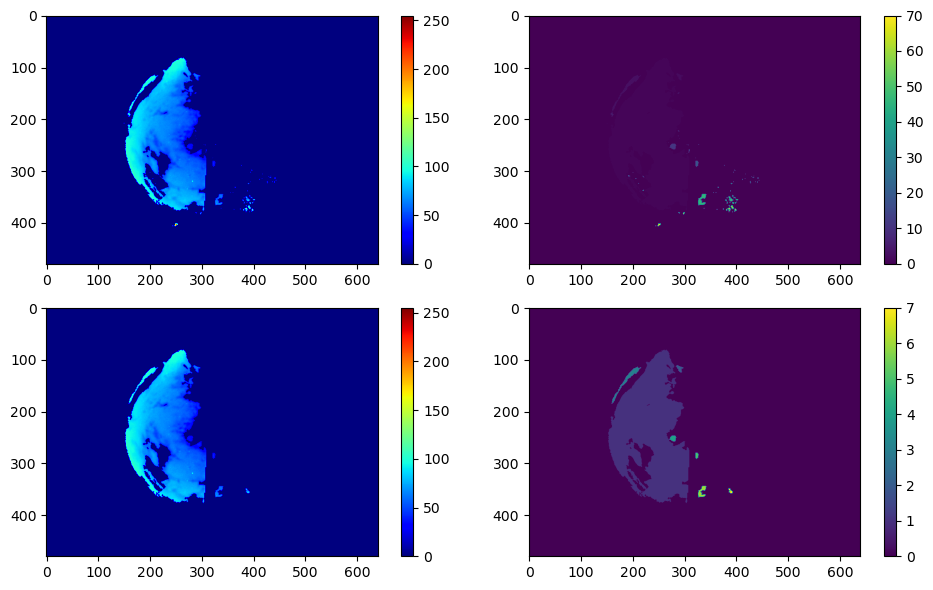

In [317]:
from skimage.measure import label, regionprops
clouds = rgba_image[:,:,0]*binary
cloud_mask= label(binary)

def remove_small(slc, c=0.0001):
    new_slc = slc.copy()
    labels = label(slc,connectivity=1,background=0)
    rps = regionprops(labels)
    areas = np.array([r.area for r in rps])
    idxs = np.where(areas/(640*480) < c)[0]
    for i in idxs:
        new_slc[tuple(rps[i].coords.T)] = 0
    return new_slc

big_mask = remove_small(binary)
label_big_mask = label(big_mask)
big_clouds = rgba_image[:,:,0]*big_mask


plt.figure(figsize=(10,6))
plt.subplot(2,2,1)
plt.imshow(clouds, cmap='jet', vmin=0, vmax=255)
plt.colorbar()

plt.subplot(2,2,2)
plt.imshow(cloud_mask)
plt.tight_layout()
plt.colorbar()

plt.subplot(2,2,3)
plt.imshow(big_clouds, cmap='jet', vmin=0, vmax=255)
plt.colorbar()

plt.subplot(2,2,4)
plt.imshow(label_big_mask)
plt.tight_layout()
plt.colorbar()



The whole process to load an image and segment it can be done in a single function. This will be useful for steps below and to implement a single code for the whole feature extraction process. 

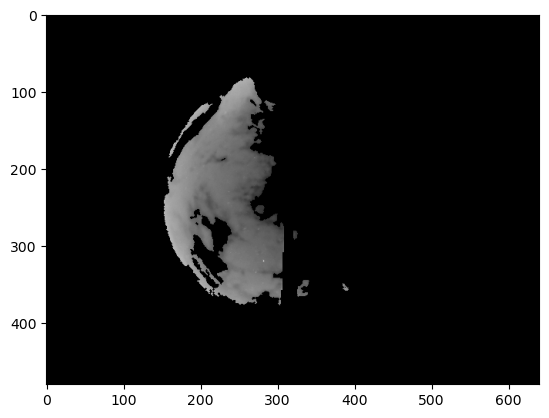

In [318]:
import imageio.v2 as imageio
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import blend_modes
from skimage.filters import threshold_yen, gaussian
from skimage.measure import label, regionprops
def TwoDToRGBA (img):
    background_img = np.array(img)  
    # Rescale the pixel values to the range [0, 255]
    scaled_img = ((background_img - np.min(background_img)) / (np.max(background_img) - np.min(background_img)) * 255).astype(np.uint8)
    # Creates an RGBA zeros image with the rescaled content
    rgba_image = np.zeros((background_img.shape[0], background_img.shape[1], 4), dtype=np.uint8)
    # The rescaled values get copied to every channel
    rgba_image[:, :, 0:3] = scaled_img[:, :, np.newaxis]
    # The alpha channel is set to a constant value of 255, for a fully opaque channel
    alpha_value = 255
    rgba_image[:, :, 3] = alpha_value
    # Now 'rgba_image' is an RGBA image with dimensions (~, ~, 4)
    return rgba_image
def TwoDToRGB(img):
    background_img = np.array(img)
    # Rescale the pixel values to the range [0, 255]
    scaled_img = ((background_img - np.min(background_img)) / (np.max(background_img) - np.min(background_img)) * 255).astype(np.uint8)
    # Create an RGB image with the rescaled content
    rgb_image = np.zeros((background_img.shape[0], background_img.shape[1], 3), dtype=np.uint8)
    # Copy the rescaled values to all three channels (RGB)
    rgb_image[:, :, :] = scaled_img[:, :, np.newaxis]
    # Now 'rgb_image' is an RGB image with dimensions (height, width, 3)
    return rgb_image
def remove_small(slc, c=0.0001):
    new_slc = slc.copy()
    labels = label(slc,connectivity=1,background=0)
    rps = regionprops(labels)
    areas = np.array([r.area for r in rps])
    idxs = np.where(areas/(640*480) < c)[0]
    for i in idxs:
        new_slc[tuple(rps[i].coords.T)] = 0
    return new_slc
def create_radial_gradient(size, center, radius):
    y, x = np.ogrid[:size[0], :size[1]]
    distance = np.sqrt((x - center[1]) ** 2 + (y - center[0]) ** 2)
    gradient = 1 - np.clip(distance / radius, 0, 1)
    return gradient
def multiply_with_gradient(image, gradient, opacity):
    background_img_float = image.astype(float)
    foreground_img_float = gradient.astype(float)
    blended_img_float = blend_modes.multiply(background_img_float, foreground_img_float, opacity)
    # Convert blended image back into PIL image
    blended_img = np.uint8(blended_img_float)
    return blended_img
def segmentation(filepath): 
    # Read the JP2 image
    image = imageio.imread(filepath)
    # Image gets converted to int32
    int_img = image.astype(int)
    # # camera mask is multiplied to the image to make it the darkest part of it by -1
    camara = Image.open('camera.png')
    camara = np.asarray(camara)
    # Only the alpha channel is needed, and is divided by 255 to get the number in the range [0,1]
    slicee = camara[:,:,3]/255
    img = int_img * slicee
    img[img<1000] = np.max(np.min(int_img) - 1, 0)
    rgba_image = TwoDToRGBA (img)
    image_size = img.shape
    gradient_center = (235, 314)  # Center of the gradient correponding to the center of the camera
    gradient_radius = 210  # Radius of the gradient
    gradient_1 = create_radial_gradient(image_size, gradient_center, gradient_radius)
    rgba_grad_1 = TwoDToRGBA (gradient_1)
    gradient_radius = 250  # Radius of the gradient
    gradient_2 = create_radial_gradient(image_size, gradient_center, gradient_radius)
    rgba_grad_2 = TwoDToRGBA (gradient_2)
    first_grad = multiply_with_gradient(rgba_image, rgba_grad_1, 1)
    second_grad = multiply_with_gradient(first_grad, rgba_grad_2, 1)
    gauss = gaussian(first_grad[:,:,0], sigma=0.5)
    scaled_img = ((gauss - np.min(gauss)) / (np.max(gauss) - np.min(gauss)) * 255)
    thresh  = threshold_yen(scaled_img)
    binary = scaled_img > thresh
    big_mask = remove_small(binary)
    label_big_mask = label(big_mask)
    big_clouds = rgba_image[:,:,0]*big_mask


    # For ease of use the single channel image gets converted to RGB (similar to the RGBA process)
    output_img = TwoDToRGB(big_clouds)


    return label_big_mask, output_img

# path to jp2 image
filepath = '20230807/20230807152030.jp2'
label_big_mask, output_img = segmentation(filepath)

plt.imshow(output_img)


### 3. Optical Flow

Optical flow is used to determine the velocity in objects in an image. In this case an implementation using Farnebacks algorithm for optical flow was implemented. Optical flow uses images in a sequence, as so two cosecutive images need to be provided.



In [319]:
# The two consecutive images get loaded and segmentations is applied
# filepath = '20230807/20230807152030.jp2'
# next_filepath = '20230807/20230807152100.jp2'

# filepath = '20230807/20230807171730.jp2'
# next_filepath = '20230807/20230807171800.jp2'

filepath = '20230807/20230807180130.jp2'
next_filepath = '20230807/20230807180200.jp2'

# filepath = '20230807/20230807124600.jp2'
# next_filepath = '20230807/20230807124630.jp2'

# filepath = '20230807/20230807155630.jp2'
# next_filepath = '20230807/20230807155700.jp2'

# filepath = '20230807/20230807184630.jp2'
# next_filepath = '20230807/20230807184700.jp2'

prev_mask, prev_img = segmentation(filepath)
mask, img = segmentation(next_filepath)

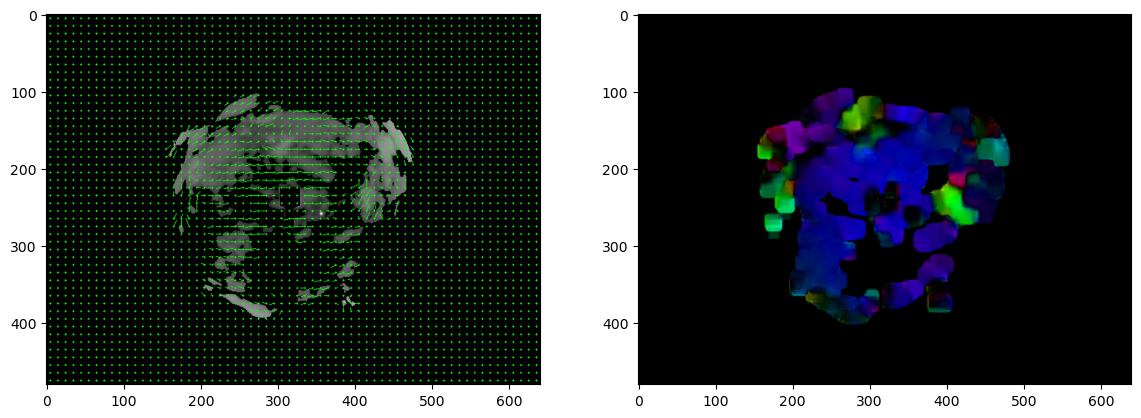

In [320]:
import cv2
import time

def draw_flow(img, flow, step=10):

    h, w = img.shape[:2]
    y, x = np.mgrid[step/2:h:step, step/2:w:step].reshape(2,-1).astype(int)
    fx, fy = flow[y,x].T

    lines = np.vstack([x, y, x-fx, y-fy]).T.reshape(-1, 2, 2)
    lines = np.int32(lines + 0.5)

    img_bgr = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    cv2.polylines(img_bgr, lines, 0, (0, 255, 0))

    for (x1, y1), (_x2, _y2) in lines:
        cv2.circle(img_bgr, (x1, y1), 1, (0, 255, 0), -1)

    return img_bgr

def draw_hsv(flow):

    hsv = np.zeros_like(img)
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    hsv[..., 0] = ang*180/np.pi/2
    hsv[..., 1] = 255
    hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
    bgr = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    
    return bgr, mag, ang, hsv

prevgray = cv2.cvtColor(prev_img, cv2.COLOR_BGR2GRAY)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

flow = cv2.calcOpticalFlowFarneback(prevgray, gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)
# prevgray = gray

draw_flow_img = draw_flow(gray, flow)
draw_flow_prev = draw_flow(prevgray, flow)
draw_hsv_img, mag, ang, hsv = draw_hsv(flow)


plt.figure(figsize=(14,8))
plt.subplot(1,2,1)
plt.imshow(draw_flow_img)


plt.subplot(1,2,2)
plt.imshow(draw_hsv_img)


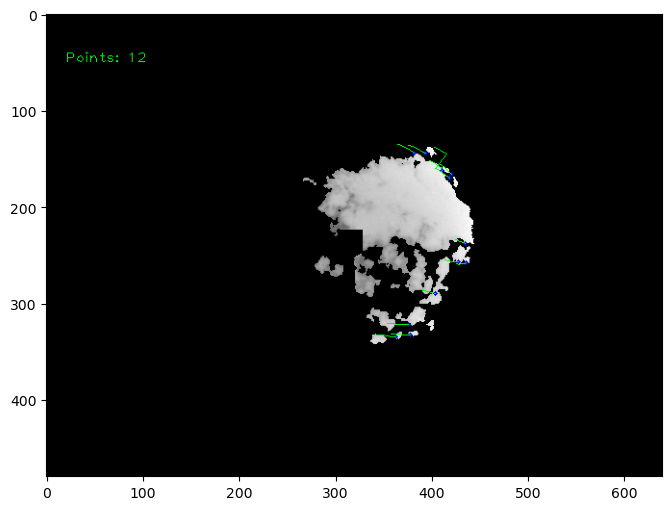

In [324]:
import os

lk_params = dict(winSize=(15, 15),
                  maxLevel=2,
                  criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

feature_params = dict(maxCorners=20,
                      qualityLevel=0.3,
                      minDistance=10,
                      blockSize=7)

trajectory_len = 40
detect_interval = 5
trajectories = []
frame_idx = 0

# Specify the path to the folder containing images
# image_folder = 'strip'
image_folder = '20230807'


# Get the list of image files in the folder
image_files = sorted([f for f in os.listdir(image_folder) if f.endswith(('.jpg', '.png', '.jpeg', '.jp2'))])
first_im = os.path.join(image_folder, image_files[0])
mask_1, prev_gray = segmentation(first_im)


for image_file in image_files[70:90]:
    # Construct the full path to the image
    image_path = os.path.join(image_folder, image_file)

    # Read the image
    mask_1, frame = segmentation(image_path)
    
    # frame = cv2.imread(image_path)
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    lk_img = frame.copy()

    # Calculate optical flow for a sparse feature set using the iterative Lucas-Kanade Method
    if len(trajectories) > 0:
        img0, img1 = prev_gray, frame_gray
        p0 = np.float32([trajectory[-1] for trajectory in trajectories]).reshape(-1, 1, 2)
        p1, _st, _err = cv2.calcOpticalFlowPyrLK(img0, img1, p0, None, **lk_params)
        p0r, _st, _err = cv2.calcOpticalFlowPyrLK(img1, img0, p1, None, **lk_params)
        d = abs(p0-p0r).reshape(-1, 2).max(-1)
        good = d < 1

        new_trajectories = []

        # Get all the trajectories
        for trajectory, (x, y), good_flag in zip(trajectories, p1.reshape(-1, 2), good):
            if not good_flag:
                continue
            trajectory.append((x, y))
            if len(trajectory) > trajectory_len:
                del trajectory[0]
            new_trajectories.append(trajectory)
            # Newest detected point
            cv2.circle(lk_img, (int(x), int(y)), 2, (0, 0, 255), -1)

        trajectories = new_trajectories

        # Draw all the trajectories
        cv2.polylines(lk_img, [np.int32(trajectory) for trajectory in trajectories], False, (0, 255, 0))
        cv2.putText(lk_img, 'Points: %d' % len(trajectories), (20, 50), cv2.FONT_HERSHEY_PLAIN, 1, (0,255,0), 1)

    # Update interval - When to update and detect new features
    if frame_idx % detect_interval == 0:
        mask = np.zeros_like(frame_gray)
        mask[:] = 255

        # Lastest point in latest trajectory
        for x, y in [np.int32(trajectory[-1]) for trajectory in trajectories]:
            cv2.circle(mask, (x, y), 5, 0, -1)

        # Detect the good features to track
        p = cv2.goodFeaturesToTrack(frame_gray, mask=mask, **feature_params)
        if p is not None:
            # If good features can be tracked - add that to the trajectories
            for x, y in np.float32(p).reshape(-1, 2):
                trajectories.append([(x, y)])

    frame_idx += 1
    prev_gray = frame_gray

    # Show Results
    cv2.imshow('Optical Flow', lk_img)
    # cv2.imshow('Mask', mask)

    if cv2.waitKey(10) & 0xFF == ord('q'):
        break

cv2.destroyAllWindows()

plt.figure(figsize=(10,6))
plt.imshow(lk_img)

In [322]:
from skimage import measure, color
from skimage.filters import threshold_otsu

#### Label for velocity 
# Read the image
image = draw_hsv_img
# Convert the image to the Lab color space
image_lab = color.rgb2lab(image)
# Separate the L, a, and b channels
L, a, b = image_lab[:, :, 0], image_lab[:, :, 1], image_lab[:, :, 2]
# Use Otsu's thresholding on the L channel to create a binary mask
thresh = threshold_otsu(L)
binary_mask = L > thresh
small_binary = remove_small(binary_mask)
# Label connected components in the binary mask
labeled_image, num_labels = label(small_binary, connectivity=2, return_num=True)
# Display the original image, binary mask, and labeled image
# io.imshow(image)
# io.show()

# io.imshow(labeled_image)
# io.show()


for num in range(1,num_labels+1):
    num_mask = labeled_image == num
    x_flow = flow[:,:,0] * num_mask
    y_flow = flow[:,:,1] * num_mask
    non_zero_elements_x = x_flow[x_flow != 0]
    non_zero_elements_y = y_flow[y_flow != 0]
    average_non_zero_x = np.average(non_zero_elements_x)
    average_non_zero_y = np.average(non_zero_elements_y)
    
    over_img = img[:,:,0] * num_mask
    mask_over_img = over_img !=0
    small_ovr = remove_small(mask_over_img, c=0.0001)
    label_over_small, small_id = label(small_ovr, return_num=True)

    for labl in range(1,small_id+1): 
        centroide = measure.centroid(label_over_small == labl)   
        line_img = cv2.arrowedLine(img,
                            (int(centroide[1]), int(centroide[0])),
                            (int(centroide[1] + average_non_zero_x * 5), int(centroide[0] + average_non_zero_y * 5)),
                            (0,255,0), 2)

### 4. Solar Position

To get the solar position PVlib library was used. This library allowed us to get the solar position for a specific set of coordinates from where the images were taken. This takes into account the time of the year. 

C:\Users\rodhe\AppData\Local\Temp\ipykernel_20824\2257565594.py:15: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  times = pd.date_range('2023-01-01 00:00:00', '2024-12-31', closed='left',


Average value within the disk: 34.156306144448436


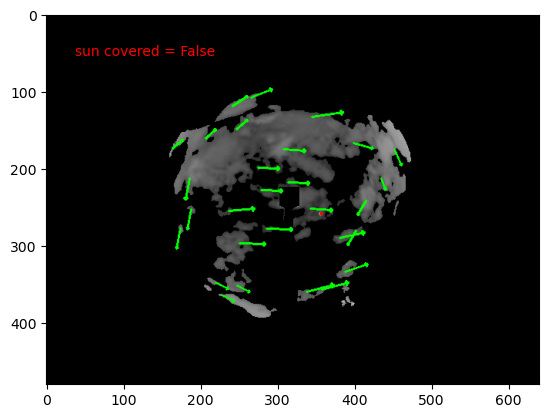

In [323]:
import pvlib
import pandas as pd

# filepath = '20230808_normal/20230808190630.png'


def solar_pos(filepath):
    
    tz = 'America/Bogota'
    lat, lon = 9.789103, -73.722451 # 9.789103, -73.722451 Esta es las coordenas
    altitude = 50

    #Ubicación Geográfica
    location = pvlib.location.Location(lat, lon, tz, altitude)
    times = pd.date_range('2023-01-01 00:00:00', '2024-12-31', closed='left',
                          freq='H', tz=tz)
    solpos = pvlib.solarposition.get_solarposition(times, lat, lon)
    # remove nighttime
    solpos = solpos.loc[solpos['apparent_elevation'] > 0, :]
    # draw hour labels
    for hour in np.unique(solpos.index.hour):
        # choose label position by the smallest radius for each hour
        subset = solpos.loc[solpos.index.hour == hour, :]
        r = subset.apparent_zenith
        pos = solpos.loc[r.idxmin(), :]
        # ax.text(np.radians(pos['azimuth']), pos['apparent_zenith'], str(hour))
    YY = filepath[-18:-14]
    MM = filepath[-14:-12]
    DD = filepath[-12:-10]
    day = YY+'-'+MM+'-'+DD
    # draw individual days
    for date in pd.to_datetime([day]):
        times = pd.date_range(date, date+pd.Timedelta('24h'), freq='30s', tz=tz)
        solpos = pvlib.solarposition.get_solarposition(times, lat, lon)
        solpos = solpos.loc[solpos['apparent_elevation'] > 0, :]
        label = date.strftime('%Y-%m-%d')
        azimuth_radians = np.radians(solpos.azimuth)

    # Convert polar coordinates to Cartesian coordinates
    x_direct = solpos.apparent_zenith * np.sin(azimuth_radians)
    y_direct = solpos.apparent_zenith * np.cos(azimuth_radians)

    # Adjust Cartesian coordinates for a (480,640) image
    x = -(x_direct)*3.18+312
    k=0.0073; x0=304.4; a=85; L=477
    x_mapped = L / (1 + np.exp(-k * (x - x0))) + a
    y_mapped =  y_direct*2 + 238

    # Rotate about center 3.5 degrees
    x_c = 314; y_c = 235; j_rot = np.deg2rad(3.5)
    x_rot = (x_mapped - x_c)* np.cos(j_rot)- (y_mapped-y_c)*np.sin(j_rot) + x_c
    y_rot = (x_mapped - x_c)* np.sin(j_rot)+ (y_mapped-y_c)*np.cos(j_rot) + y_c

    # Reflect about x axis
    x_final = x_rot - 13
    y_final = -y_rot + 478


    return x_final, y_final, day


# gets the time from the filepath following the convention '~/YYYYMMDDhhmmss.png'
def get_time (filepath):
    st = filepath[-10:-4]
    hh = str(int(st[0:2])-5)
    if len(hh) == 1:
        hh = '0'+hh
    mm = st[2:4]
    ss = st[4:6]
    timer = hh + ':'+ mm + ':' + ss
    
    
    
    return timer

def get_solar_coords (x_mapped, y_mapped, day, timer):
    x = x_mapped[day + ' ' + timer + '-05:00']
    y = y_mapped[day + ' ' + timer + '-05:00']
    
    return x, y
    
    
x_mapped, y_mapped, day = solar_pos(filepath)
timer = get_time (filepath)
solar_x, solar_y =  get_solar_coords (x_mapped, y_mapped, day, timer)
solar_y = 480 - solar_y

from skimage.draw import disk
def average_disk_value(image, center, inner_radius, outer_radius):
    # Create an array of coordinates for the disk
    rr, cc = disk(center, outer_radius)
    
    # Remove coordinates outside the inner radius
    inner_rr, inner_cc = disk(center, inner_radius)
    mask = np.in1d(rr, inner_rr) & np.in1d(cc, inner_cc)
    rr, cc = rr[mask], cc[mask]
    
    # Extract pixel values within the disk
    values = image[rr, cc]
    
    # Calculate and return the average value
    average_value = np.mean(values)
    return average_value

# Example usage
point = (solar_y, solar_x)  # Replace this with the coordinates of your point

inner_radius = 29
outer_radius = 30

result = average_disk_value(img, point, inner_radius, outer_radius)
print("Average value within the disk:", result)


covered = mask[round(solar_x),round(solar_y)] > 0


img = line_img
# Create a figure and axis for the imag
fig, ax = plt.subplots()
ax.imshow(img)
ax.plot(solar_x, solar_y, 'r.', markersize=3, label=label)
ax.text(0.2, 0.9, 'sun covered = '+str(covered), color = 'r',horizontalalignment='center',
     verticalalignment='center', transform=ax.transAxes)
# ax.plot(x_mapped, y_mapped,'r' , label=label)

# plt.savefig('foo.png')
# plt.close() 
plt.show()